### Cell A — Imports & Config

In [1]:
# === Cell A — Imports, reproducibility, load balanced ROI manifest ===
import os, random
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import cv2
from tqdm.auto import tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

# Keep CPU threads tame
torch.set_num_threads(1)

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"

# Use the specific balanced ROI manifest you showed
man_path = data_dir / "manifest_nslt2000_roi_top104_balanced_clean.csv"
assert man_path.exists(), f"Manifest not found: {man_path}"

df = pd.read_csv(man_path)
print("Loaded:", man_path)
print(f"Samples: {len(df)} | classes={df['gloss'].nunique()}")
print("Columns:", df.columns.tolist())

print("label_new min/max:", df["label_new"].min(), df["label_new"].max())
print("label_new nunique:", df["label_new"].nunique())

df.head()


Loaded: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_nslt2000_roi_top104_balanced_clean.csv
Samples: 1159 | classes=104
Columns: ['video_id', 'path', 'gloss', 'label', 'split', 'exists', 'label_new']
label_new min/max: 0 103
label_new nunique: 104


,video_id,path,gloss,label,split,exists,label_new
0,639,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
1,624,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
2,632,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
3,623,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0
4,65009,/home/falasoul/notebooks/USD/AAI-590/Capstone/...,accident,8,train,True,0


### Cell B — WLASLDataset (using ROI + label_new) + WLASLDataset with on-the-fly augmentations

In [2]:
# === Cell B — WLASLDataset (ROI, label_new) with safe loading + on-the-fly augmentation ===
import torch, numpy as np, cv2, decord, random
from torch.utils.data import Dataset
decord.bridge.set_bridge('torch')


def _resize_112(frame_tchw: torch.Tensor) -> torch.Tensor:
    T, C, H, W = frame_tchw.shape
    arr = frame_tchw.permute(0, 2, 3, 1).cpu().numpy()
    out = np.empty((T, 112, 112, C), dtype=np.float32)
    for t in range(T):
        out[t] = cv2.resize(arr[t], (112, 112), interpolation=cv2.INTER_AREA)
    return torch.from_numpy(out).permute(0, 3, 1, 2)


def _normalize(frame_tchw, mean=(0.45,)*3, std=(0.225,)*3):
    mean = torch.tensor(mean, dtype=frame_tchw.dtype, device=frame_tchw.device)[None, :, None, None]
    std  = torch.tensor(std,  dtype=frame_tchw.dtype, device=frame_tchw.device)[None, :, None, None]
    return (frame_tchw - mean) / std


def uniform_temporal_indices(n_total, clip_len, stride):
    if n_total <= 0:
        return [0] * clip_len
    wanted = (clip_len - 1) * stride + 1
    if n_total >= wanted:
        start = (n_total - wanted) // 2
        return [start + i * stride for i in range(clip_len)]
    idxs = [min(i * stride, n_total - 1) for i in range(clip_len)]
    return idxs


class WLASLDataset(Dataset):
    def __init__(self, df, clip_len=32, stride=2, train=False):
        self.df = df.reset_index(drop=True)
        self.clip_len = clip_len
        self.stride = stride
        self.train = train

    def __len__(self):
        return len(self.df)

    # --------- augmentation helpers (on-the-fly, train only) ---------
    def _augment(self, frames: torch.Tensor) -> torch.Tensor:
        """
        frames: [T, C, H, W], values in [0,1] (float32).
        Only applied when self.train == True.
        """
        if not self.train:
            return frames

        T, C, H, W = frames.shape

        # 1) Random horizontal flip
        if random.random() < 0.5:
            frames = torch.flip(frames, dims=[3])  # flip width

        # 2) Random Gaussian blur
        if random.random() < 0.3:
            k = random.choice([3, 5])
            fr_np = frames.permute(0, 2, 3, 1).cpu().numpy()  # [T,H,W,C]
            for t in range(T):
                fr_np[t] = cv2.GaussianBlur(fr_np[t], (k, k), 0)
            frames = torch.from_numpy(fr_np).permute(0, 3, 1, 2)

        # 3) Random brightness / contrast
        if random.random() < 0.3:
            alpha = 1.0 + 0.4 * (random.random() - 0.5)   # contrast ~ [0.8, 1.2]
            beta  = 0.1 * (random.random() - 0.5)         # brightness ~ [-0.05, 0.05]
            frames = frames * alpha + beta
            frames = frames.clamp(0.0, 1.0)

        # 4) Random cutout mask (simulate occlusion)
        if random.random() < 0.3:
            mask_size = random.randint(16, 40)
            y0 = random.randint(0, max(0, H - mask_size))
            x0 = random.randint(0, max(0, W - mask_size))
            frames[:, :, y0:y0+mask_size, x0:x0+mask_size] = 0.0

        return frames

    def _safe_load_clip(self, path: str) -> torch.Tensor:
        """
        Try to read a clip with decord. If anything fails, return a dummy zero clip.
        Returned shape: [T, C, H, W], float32 in [0,1].
        """
        try:
            vr = decord.VideoReader(path)
            n = len(vr)
            if n <= 0:
                raise RuntimeError("no frames")

            idxs = uniform_temporal_indices(n, self.clip_len, self.stride)
            batch = vr.get_batch(idxs)        # [T,H,W,C]
            x = batch.float() / 255.0         # [0,1]
            x = x.permute(0, 3, 1, 2)         # [T,C,H,W]
            x = _resize_112(x)                # [T,3,112,112]
            x = self._augment(x)              # on-the-fly aug (train only)
            x = _normalize(x)                 # final normalization
            return x
        except Exception as e:
            print(f"[WARN] Failed to read video {path}: {e} — using zero clip.")
            x = torch.zeros(self.clip_len, 3, 112, 112, dtype=torch.float32)
            x = _normalize(x)
            return x

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["path"]
        label = int(row["label_new"])   # contiguous 0..C-1

        x = self._safe_load_clip(path)
        return x, label, path


#### Cell C — Split DataFrames & DataLoaders (single worker)

In [3]:
# === Cell C — Splits + DataLoaders (no multiprocessing) ===

train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print("Split sizes:", len(train_df), "train |", len(val_df), "val |", len(test_df), "test")

clip_len = 32
stride   = 2
batch_size = 4   # small to be safe on GPU

train_ds = WLASLDataset(train_df, clip_len=clip_len, stride=stride, train=True)
val_ds   = WLASLDataset(val_df,   clip_len=clip_len, stride=stride, train=False)
test_ds  = WLASLDataset(test_df,  clip_len=clip_len, stride=stride, train=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,              # 🔒 NO worker processes
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == "cuda"),
)

x_dbg, y_dbg, _ = next(iter(train_loader))
print("Sample batch shape:", x_dbg.shape, "| labels range:", y_dbg.min().item(), "->", y_dbg.max().item())


Split sizes: 831 train | 192 val | 136 test
Device: cuda
Sample batch shape: torch.Size([4, 32, 3, 112, 112]) | labels range: 60 -> 88
Sample batch shape: torch.Size([4, 32, 3, 112, 112]) | labels range: 60 -> 88


#### Cell D — Model: R3D-18 baseline

In [4]:
# === Cell D — CNN + BiGRU model with PRETRAINED ResNet-18 ===

from torchvision.models import resnet18
from torchvision.models.video import r3d_18, R3D_18_Weights

num_classes = df["label_new"].nunique()
print("num_classes:", num_classes)

weights = R3D_18_Weights.KINETICS400_V1
base = r3d_18(weights=weights)


in_f = base.fc.in_features
base.fc = nn.Linear(in_f, num_classes)   # num_classes = 104 from df["label_new"]

model = base.to(device)
print("Model:", "r3d18_k400")


num_classes: 104
Model: r3d18_k400
Model: r3d18_k400


#### Cell E — Optimizer, Scaler, Loss

In [5]:
# === Cell E — Optimizer, scaler, loss (pretrained) ===
from torch.amp import GradScaler

epochs = 20
lr     = 1e-4      # 🔽 slightly lower than 3e-4 used for scratch
wd     = 1e-2
amp_on = True

opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = GradScaler(enabled=amp_on)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # can keep or remove smoothing
best_val_acc = -1.0


#### Cell F — run_epoch (with correct [B,C,T,H,W] permute)

In [6]:
# === Cell F — Metrics + epoch runner (for CNN+BiGRU) ===

def top1_acc(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_acc  = 0.0
    total_n    = 0

    opt.zero_grad(set_to_none=True)

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)  # [B,T,C,H,W]
        y = y.to(device, non_blocking=True)

        # 🔽 New: permute for 3D CNN
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # [B,C,T,H,W]

        with torch.amp.autocast(device_type=device.type, enabled=amp_on):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)

        with torch.no_grad():
            acc = top1_acc(logits, y)
            bs  = x.size(0)
            total_loss += loss.item() * bs
            total_acc  += acc * bs
            total_n    += bs

    return total_loss / total_n, total_acc / total_n



#### Cell G — Training Loop

In [7]:
# === Cell G — Training Loop ===
# Ensure root, checkpoint and report dirs
root = Path("..").resolve()
ckpt_dir = root / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)
report_dir = root / "reports"
report_dir.mkdir(parents=True, exist_ok=True)

# Notebook-based prefix for artifact filenames (sanitized)
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')

# names
best_path = ckpt_dir / f"{nb_prefix}_best_cnn_Kinetics-400s.pt"
save_path = best_path

# history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)

    # record
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), str(save_path))
        print(f"  ➜ New best val acc={best_val_acc:.3f} (model saved to {save_path})")

# persist history so later cells (or reruns) can load it
import json, datetime
history_path = report_dir / f'{nb_prefix}_train_history.json'
with open(str(history_path), 'w') as _f:
    json.dump(history, _f)
print("Saved training history to", history_path)


Epoch 01/20 | train loss 4.6809 acc 0.034 | val loss 4.3450 acc 0.057
  ➜ New best val acc=0.057 (model saved to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics_best_cnn_Kinetics-400s.pt)
Epoch 02/20 | train loss 4.0246 acc 0.194 | val loss 3.9596 acc 0.167
  ➜ New best val acc=0.167 (model saved to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics_best_cnn_Kinetics-400s.pt)
Epoch 02/20 | train loss 4.0246 acc 0.194 | val loss 3.9596 acc 0.167
  ➜ New best val acc=0.167 (model saved to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics_best_cnn_Kinetics-400s.pt)
Epoch 03/20 | train loss 3.5052 acc 0.373 | val loss 3.6613 acc 0.203
  ➜ New best val acc=0.203 (model saved to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints/06_train_baseline_3dCNN-r3d18_k400_kenetics

In [8]:
# === Load best checkpoint (uses notebook-prefixed filename when available) ===
ckpt_dir = root / "checkpoints"
# Use nb_prefix computed earlier if available, otherwise fallback to sanitized notebook stem
nb_prefix = globals().get('nb_prefix', Path("06_train_baseline_3dCNN-r3d18_k400_kenetics.ipynb").stem.replace(' ', '_'))
best_path = ckpt_dir / f"{nb_prefix}_best_cnn_Kinetics-400s.pt"

if not best_path.exists():
    print(f"Best model not found at {best_path}. Please run training or verify checkpoint name.")
else:
    model.load_state_dict(torch.load(str(best_path), map_location=device))
    model.to(device)

    test_loss, test_acc = run_epoch(test_loader, train=False)
    print(f"TEST — loss {test_loss:.4f} | acc {test_acc:.3f}")


TEST — loss 3.0753 | acc 0.404


Loaded history from /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics_train_history.json


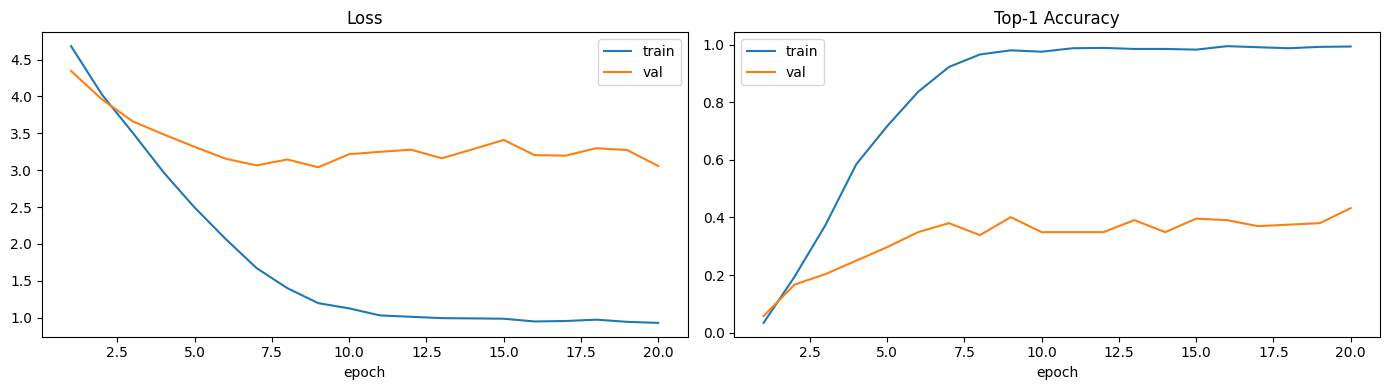

Evaluating test set:   0%|          | 0/34 [00:00<?, ?it/s]

Test Top-1 accuracy: 0.4044 (N=136)


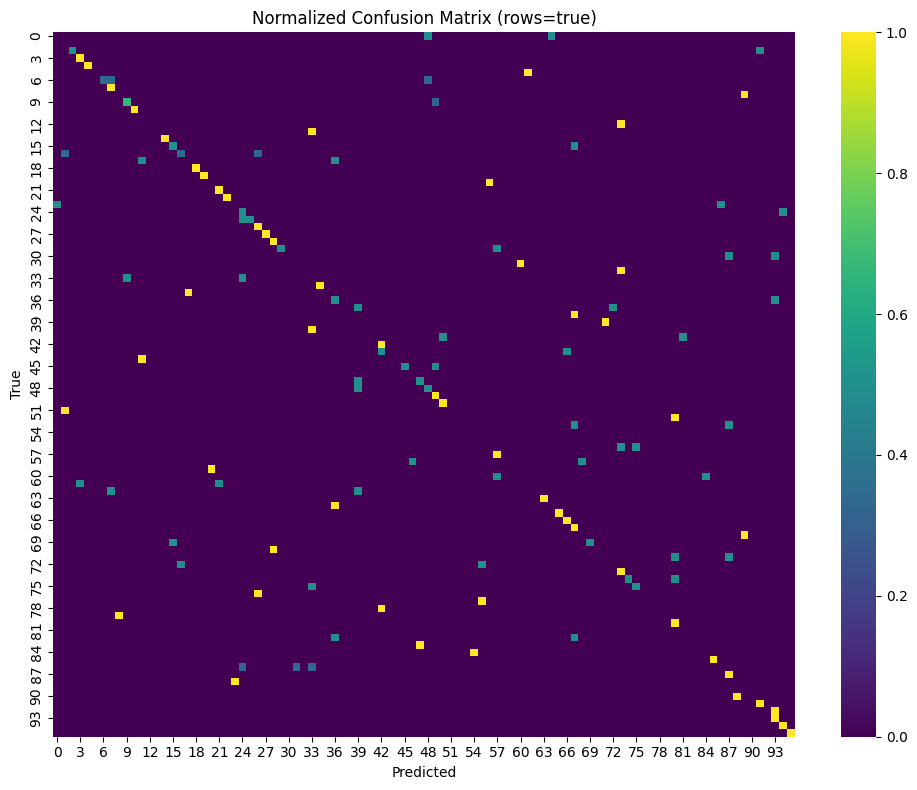

,label,gloss,accuracy,support
0,27,cousin,1.0,2
1,29,dark,1.0,2
2,22,cold,1.0,2
3,88,thin,1.0,2
4,72,score,1.0,2
5,53,last,1.0,2
6,70,room,1.0,2
7,55,laugh,1.0,2
8,101,year,1.0,2
9,74,shirt,1.0,2



Saved classification report (json & txt) at: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics_classification_report.json /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports/06_train_baseline_3dCNN-r3d18_k400_kenetics_classification_report.txt

Saved test_report.json and test_report.txt to /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/reports


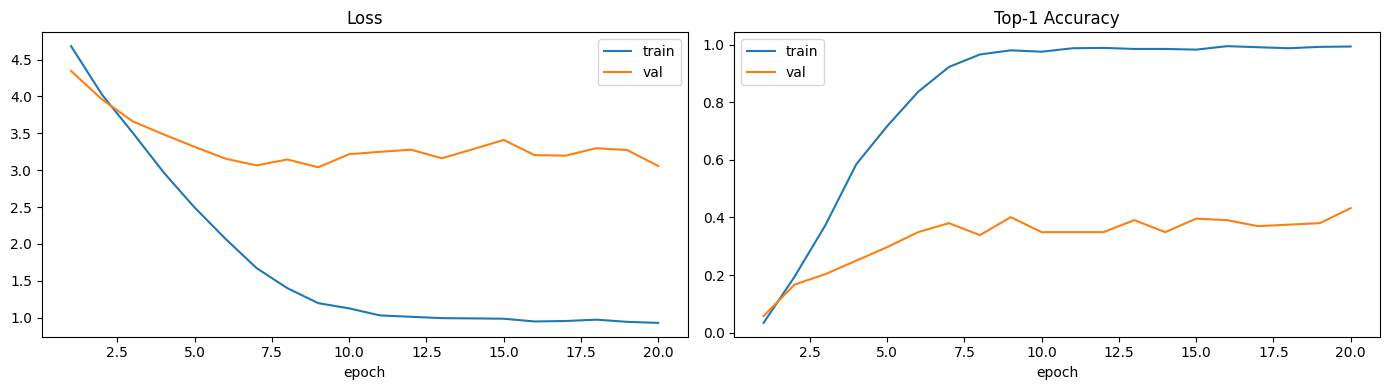

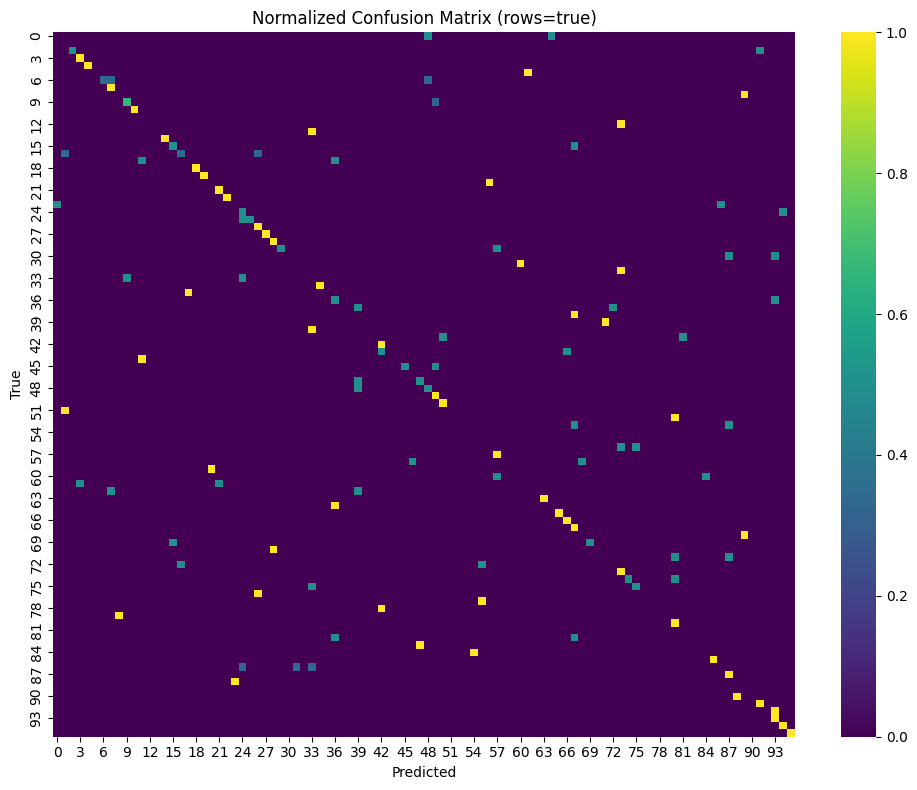

In [9]:
# === Cell H — Evaluation, Plots and Test Report ===
"""
Load training history and the best checkpoint, evaluate on the test set,
plot train/val curves, normalized confusion matrix (for labels actually present),
compute per-class accuracy and classification report. Save artifacts to `reports/`
with filenames prefixed by the notebook stem so they're unique per-notebook.
"""

import os, time, json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# directories and prefix
ckpt_dir = root / "checkpoints"
report_dir = root / "reports"
report_dir.mkdir(parents=True, exist_ok=True)
nb_stem = Path("06_train_baseline_3dCNN-r3d18_k400_kenetics.ipynb").stem
nb_prefix = str(nb_stem).replace(' ', '_')

# load history
history_file = report_dir / f"{nb_prefix}_train_history.json"
history = None
if history_file.exists():
    with open(str(history_file), 'r') as f:
        history = json.load(f)
        print('Loaded history from', history_file)

# plot curves if available
curves_path = None
if history is not None:
    epochs_ran = len(history.get('train_loss', []))
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(range(1, epochs_ran+1), history.get('train_loss', []), label='train')
    axs[0].plot(range(1, epochs_ran+1), history.get('val_loss', []), label='val')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    axs[1].plot(range(1, epochs_ran+1), history.get('train_acc', []), label='train')
    axs[1].plot(range(1, epochs_ran+1), history.get('val_acc', []), label='val')
    axs[1].set_title('Top-1 Accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend()

    plt.tight_layout()
    curves_path = report_dir / f"{nb_prefix}_train_val_curves.png"
    plt.savefig(str(curves_path), dpi=150)
    display(fig)
else:
    print('No training history found; skipping curve plots.')

# load best model
best_model_path = ckpt_dir / f"{nb_prefix}_best_cnn_Kinetics-400s.pt"
if not best_model_path.exists():
    print(f'Best model not found at {best_model_path}. Skipping test evaluation.')
else:
    model.load_state_dict(torch.load(str(best_model_path), map_location=device))
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    paths = []

    with torch.no_grad():
        for x, y, pth in tqdm(test_loader, desc='Evaluating test set'):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            # permute to [B,C,T,H,W] because this notebook uses torchvision r3d_18 (expects [B,C,T,H,W])
            x = x.permute(0, 2, 1, 3, 4).contiguous()

            with torch.amp.autocast(device_type=device.type, enabled=amp_on):
                logits = model(x)
                preds = logits.argmax(1)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            paths.extend(pth)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    test_acc = float((y_true == y_pred).mean())
    print(f'Test Top-1 accuracy: {test_acc:.4f} (N={len(y_true)})')

    # mapping label->gloss if available
    label_to_name = None
    if 'df' in globals():
        label_map_df = df[['label_new', 'gloss']].drop_duplicates()
        label_to_name = {int(r['label_new']): r['gloss'] for _, r in label_map_df.iterrows()}

    # only consider labels actually present in either y_true or y_pred
    present_labels = np.union1d(np.unique(y_true), np.unique(y_pred)).astype(int)
    labels_list = present_labels.tolist()

    # names list for present labels
    if label_to_name is not None:
        names_list = [label_to_name.get(int(l), str(int(l))) for l in labels_list]
    else:
        names_list = [str(int(l)) for l in labels_list]

    # confusion matrix for present labels
    cm = confusion_matrix(y_true, y_pred, labels=labels_list)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)

    fig, ax = plt.subplots(figsize=(10, 8))
    if len(labels_list) <= 50:
        sns.heatmap(cm_norm, xticklabels=names_list, yticklabels=names_list, cmap='viridis', vmin=0, vmax=1, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    else:
        sns.heatmap(cm_norm, cmap='viridis', vmin=0, vmax=1, ax=ax)
    ax.set_title('Normalized Confusion Matrix (rows=true)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    cm_path = report_dir / f"{nb_prefix}_confusion_matrix_norm.png"
    plt.savefig(str(cm_path), dpi=150)
    display(fig)

    # per-class accuracy
    support = cm.sum(axis=1)
    per_class_acc = (cm.diagonal().astype('float') / (support + 1e-12))
    class_acc_df = pd.DataFrame({
        'label': labels_list,
        'gloss': names_list,
        'accuracy': per_class_acc,
        'support': support
    })
    class_acc_df = class_acc_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

    display(class_acc_df.head(20))
    per_class_csv = report_dir / f"{nb_prefix}_per_class_accuracy.csv"
    class_acc_df.to_csv(str(per_class_csv), index=False)

    # classification report for present labels only (both text and JSON)
    clf_report_dict = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0, output_dict=True)
    clf_report_txt = classification_report(y_true, y_pred, labels=labels_list, target_names=names_list, zero_division=0)

    # save classification report as JSON and TXT
    clf_json_path = report_dir / f"{nb_prefix}_classification_report.json"
    with open(str(clf_json_path), 'w') as f:
        json.dump(clf_report_dict, f, indent=2)

    clf_txt_path = report_dir / f"{nb_prefix}_classification_report.txt"
    with open(str(clf_txt_path), 'w') as f:
        f.write(clf_report_txt)

    print('\nSaved classification report (json & txt) at:', clf_json_path, clf_txt_path)

    # predictions CSV
    preds_df = pd.DataFrame({'path': paths, 'y_true': y_true.tolist(), 'y_pred': y_pred.tolist()})
    preds_df['y_true_name'] = preds_df['y_true'].map(lambda x: label_to_name.get(int(x), str(int(x))) if label_to_name is not None else str(int(x)))
    preds_df['y_pred_name'] = preds_df['y_pred'].map(lambda x: label_to_name.get(int(x), str(int(x))) if label_to_name is not None else str(int(x)))
    preds_csv = report_dir / f"{nb_prefix}_predictions.csv"
    preds_df.to_csv(str(preds_csv), index=False)

    # assemble summary report for downstream writing (ChatGPT-ready)
    report = {
        'created_at': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),
        'notebook': nb_prefix,
        'model': repr(model.__class__.__name__),
        'best_model_path': str(best_model_path),
        'num_parameters': int(sum(p.numel() for p in model.parameters())),
        'num_trainable_parameters': int(sum(p.numel() for p in model.parameters() if p.requires_grad)),
        'dataset': {
            'n_train': int(len(train_df)) if 'train_df' in globals() else None,
            'n_val': int(len(val_df)) if 'val_df' in globals() else None,
            'n_test': int(len(test_df)) if 'test_df' in globals() else None,
            'num_classes_present': int(len(labels_list)),
            'num_classes_total_in_manifest': int(df['label_new'].nunique()) if 'df' in globals() else None
        },
        'evaluation': {
            'test_top1': float(test_acc),
            'n_samples': int(len(y_true)),
            'per_class_csv': str(per_class_csv),
            'confusion_matrix_png': str(cm_path),
            'classification_report_json': str(clf_json_path),
            'predictions_csv': str(preds_csv)
        },
        'training': {
            'epochs_ran': int(len(history.get('train_loss', []))) if history is not None else None,
            'best_val_acc': float(best_val_acc) if 'best_val_acc' in globals() else None,
            'hyperparameters': {
                'epochs': int(epochs) if 'epochs' in globals() else None,
                'lr': float(lr) if 'lr' in globals() else None,
                'weight_decay': float(wd) if 'wd' in globals() else None,
                'batch_size': int(batch_size) if 'batch_size' in globals() else None,
                'amp_on': bool(amp_on) if 'amp_on' in globals() else None,
                'clip_len': int(clip_len) if 'clip_len' in globals() else None,
                'stride': int(stride) if 'stride' in globals() else None
            }
        }
    }

    # save report
    test_report_json = report_dir / f"{nb_prefix}_test_report.json"
    with open(str(test_report_json), 'w') as f:
        json.dump(report, f, indent=2)

    test_report_txt = report_dir / f"{nb_prefix}_test_report.txt"
    with open(str(test_report_txt), 'w') as f:
        f.write('Test report generated on: ' + report['created_at'] + '\n\n')
        f.write('Notebook: ' + report['notebook'] + '\n')
        f.write('Model: ' + report['model'] + '\n')
        f.write(f"Best model path: {report['best_model_path']}\n")
        f.write(f"Num parameters: {report['num_parameters']} (trainable: {report['num_trainable_parameters']})\n")
        f.write('\nDataset splits:\n')
        f.write(f"  train={report['dataset']['n_train']}, val={report['dataset']['n_val']}, test={report['dataset']['n_test']}\n")
        f.write(f"Num classes (present in test): {report['dataset']['num_classes_present']}\n")
        f.write(f"Num classes (total in manifest): {report['dataset']['num_classes_total_in_manifest']}\n\n")
        f.write('Training summary:\n')
        f.write(f"  epochs ran: {report['training']['epochs_ran']}, best val acc: {report['training']['best_val_acc']}, final test acc: {report['evaluation']['test_top1']}\n")
        f.write('Hyperparameters:\n')
        for k, v in report['training']['hyperparameters'].items():
            f.write(f"  {k}: {v}\n")
        f.write('\nTop 20 per-class accuracy:\n')
        for _, row in class_acc_df.head(20).iterrows():
            f.write(f"  {int(row['label'])}\t{row['gloss']}\tacc={row['accuracy']:.3f}\tsupport={int(row['support'])}\n")

    print('\nSaved test_report.json and test_report.txt to', report_dir)
